In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split

%matplotlib inline
pd.set_option("display.mpl_style", "default")

In [2]:
# Read data from files 
train = pd.read_csv("data/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)

### Clean Up Reviews

In [3]:
# Uncomment the next line to download stop words if it's not already installed.
# nltk.download()

print stopwords.words("english") # stop word list from the nltk corpus

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [4]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

In [29]:
review_to_words(train["review"][0])

u'stuff going moment mj ve started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad m kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate 

In [5]:
# Get the number of reviews based on the dataframe column size
num_reviews = train["review"].size

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in xrange( 0, num_reviews ):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
        print "Cleaning review %d of %d\n" % ( i+1, num_reviews )                                                             
  
    # Call our function for each one, and add the result to the list of
    # clean reviews
    try:
        clean_train_reviews.append( review_to_words( train["review"][i] ) )
    except Exception as e:
        clean_train_reviews.append( review_to_words("I'm a placeholder sentence."))
        print "Execption raised:", e

Cleaning review 1000 of 25000

Cleaning review 2000 of 25000

Cleaning review 3000 of 25000

Cleaning review 4000 of 25000

Cleaning review 5000 of 25000

Cleaning review 6000 of 25000

Cleaning review 7000 of 25000

Cleaning review 8000 of 25000

Cleaning review 9000 of 25000

Cleaning review 10000 of 25000

Execption raised: error return without exception set
Cleaning review 11000 of 25000

Cleaning review 12000 of 25000

Execption raised: error return without exception set
Cleaning review 13000 of 25000

Execption raised: error return without exception set
Cleaning review 14000 of 25000

Cleaning review 15000 of 25000

Cleaning review 16000 of 25000

Cleaning review 17000 of 25000

Cleaning review 18000 of 25000

Cleaning review 19000 of 25000

Cleaning review 20000 of 25000

Cleaning review 21000 of 25000

Cleaning review 22000 of 25000

Cleaning review 23000 of 25000

Cleaning review 24000 of 25000

Cleaning review 25000 of 25000



### Load Positive And Negative Word Dictionaries

In [11]:
# http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html
positives = open("data/positive.txt").read()
negatives = open("data/negative.txt").read()
pos_word_list = positives.split('\n')
neg_word_list = negatives.split('\n')

In [12]:
# convert lists to sets for removing duplicates and faster searching
pos_word_set = set(pos_word_list)
neg_word_set = set(neg_word_list)

### Calculate Positive And Negative Word Counts for Each Review

In [16]:
train_posneg_counts = []
for review in clean_train_reviews:
    pos_count, neg_count = 0, 0
    words = review.split(' ')
    for word in words:
        if word in pos_word_set:
            pos_count += 1
        if word in neg_word_set:
            neg_count += 1
    train_posneg_counts.append(pos_count - neg_count)

### Prepare Training and Testing Datasets for Classifier

In [28]:
# Split our labeled reviews into training (70%) and testing sets (30%)
X = pd.DataFrame(train_posneg_counts)
y = train["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

### Stochastic Logistic Regression

In [30]:
lr = SGDClassifier(loss='log', penalty='l1')
lr.fit(X_train, y_train)
print 'Test Accuracy: %.2f'% lr.score(X_test, y_test)

Test Accuracy: 0.72


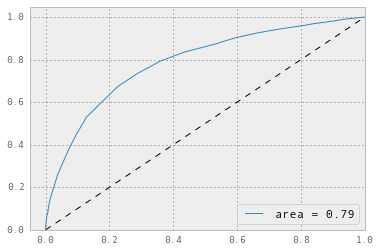

In [31]:
pred_probas = lr.predict_proba(X_test)[:,1]

false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, pred_probas)
roc_auc = auc(false_pos_rate, true_pos_rate)
plt.plot(false_pos_rate, true_pos_rate, label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

plt.show()